# Generating abstract art using DCGAN

The goal of this project is to train a DCGAN to generate new works of abstract art. The implementation will be done in PyTorch. 

This project will utilze the model proposed by the 2015 paper "UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS", which advocates the idea of using strided convolution to replace pooling layers.

Dataset used: https://www.kaggle.com/datasets/bryanb/abstract-art-gallery

Checkpoint Dataset I made: https://www.kaggle.com/datasets/therealcyberlord/abstract-art-generation-dcgan-checkpoints

![](https://github.com/therealcyberlord/DCGAN/raw/master/GIFS/gan-visulization.gif)

Sources:
* Arxiv Paper: https://arxiv.org/pdf/1511.06434v2.pdf

* This also take a lot of inspiration from the PyTorch DCGAN Tutorial, check it out <a href="https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html">here</a>



In [1]:
import torch
from torch.nn import functional as F
from torch import nn 
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np 
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline 

# set seed for replicable results 
torch.manual_seed(999)
random.seed(10)

In [2]:
image_path = "../input/abstract-art-gallery/"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

lr = 0.0002
beta1 = 0.5
epochs = 10

# we read the image data and preprocess it 

dataset = ImageFolder(root=image_path,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor(),
                               # normalize to the range [-1, 1]
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# create a dataloader 
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [3]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [4]:
# getting a batch from the dataloader 
batch = next(iter(dataloader))

# Visualize our training images

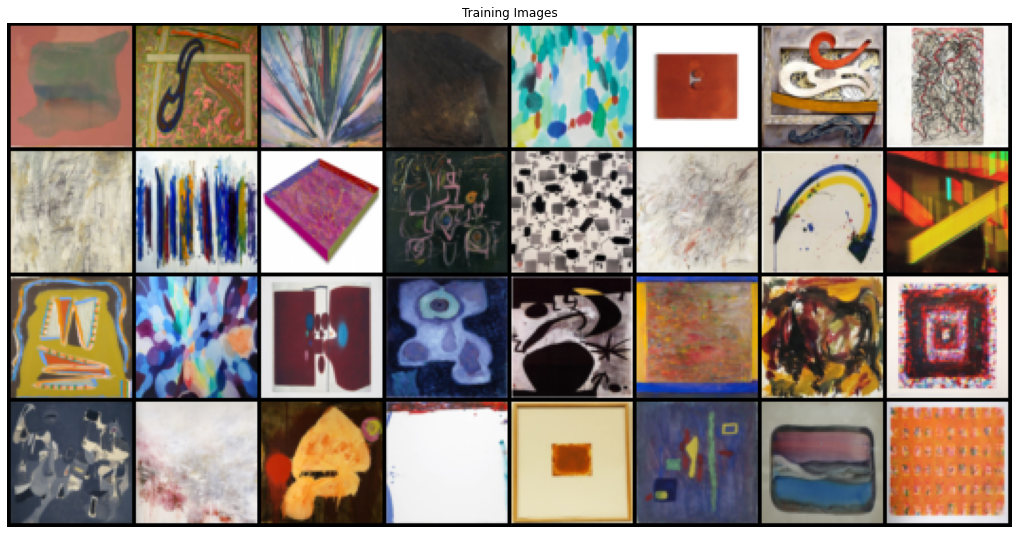

In [5]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")

# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# DCGAN Generator Architecture

In [6]:
# custom weights initialization based on the 2015 DCGAN paper 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

# Generator architecture

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [8]:
generator = Generator().to(device)
generator.apply(weights_init)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(generator)
print("Trainable Parameters:", count_parameters(generator))

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


Let's see what we get without training the generator 

In [9]:
untrained_output = generator(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

torch.Size([1, 3, 64, 64])


# Discriminator architecture

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [11]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)
print("Trainable Parameters:", count_parameters(discriminator))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


Let's see what we get without training the discriminator 

In [12]:
discriminator(untrained_output).view(-1).detach()

tensor([0.8453], device='cuda:0')

In [13]:
# cross binary entropy
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# restore to the latest checkpoint

checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])

# Training the GAN

In [15]:
generator_loss = []
discriminator_loss = [] 
iters = 0
img_list = []

In [16]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):
        
        # train the discriminator 
        discriminator.zero_grad()
        real_data = data[0].to(device)
        real_size = real_data.size(0)
        
        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)
        
        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)
        
        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()
        
        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)
        
        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)
        
        # classify all fake batch with discriminator 
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()
        
        # the sum of the discriminator 
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()
        
        # train the generator 
        generator.zero_grad()
        # pretend the generated results are real 
        label.fill_(real_label)
        
        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()
        
        # print out summary statistics 
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))
            
        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())
        
         # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1
    

  0%|          | 0/90 [00:00<?, ?it/s]

[0/10][0/90]	Loss_D: 0.0795	Loss_G: 5.8660
[0/10][10/90]	Loss_D: 0.0476	Loss_G: 5.8942
[0/10][20/90]	Loss_D: 0.1992	Loss_G: 4.9068
[0/10][30/90]	Loss_D: 0.0551	Loss_G: 6.0860
[0/10][40/90]	Loss_D: 0.0756	Loss_G: 6.7405
[0/10][50/90]	Loss_D: 0.1133	Loss_G: 5.9963
[0/10][60/90]	Loss_D: 0.0481	Loss_G: 6.4582
[0/10][70/90]	Loss_D: 0.0510	Loss_G: 5.7394
[0/10][80/90]	Loss_D: 0.0369	Loss_G: 6.0622


  0%|          | 0/90 [00:00<?, ?it/s]

[1/10][0/90]	Loss_D: 0.1851	Loss_G: 6.6535
[1/10][10/90]	Loss_D: 0.0784	Loss_G: 5.8489
[1/10][20/90]	Loss_D: 0.0966	Loss_G: 5.2306
[1/10][30/90]	Loss_D: 0.0551	Loss_G: 5.0813
[1/10][40/90]	Loss_D: 0.0547	Loss_G: 6.2836
[1/10][50/90]	Loss_D: 0.0551	Loss_G: 5.0324
[1/10][60/90]	Loss_D: 0.0574	Loss_G: 5.5354
[1/10][70/90]	Loss_D: 0.0400	Loss_G: 5.7406
[1/10][80/90]	Loss_D: 0.0741	Loss_G: 5.0526


  0%|          | 0/90 [00:00<?, ?it/s]

[2/10][0/90]	Loss_D: 0.0401	Loss_G: 6.4919
[2/10][10/90]	Loss_D: 0.1590	Loss_G: 6.7262
[2/10][20/90]	Loss_D: 0.1746	Loss_G: 6.3638
[2/10][30/90]	Loss_D: 0.0861	Loss_G: 5.9765
[2/10][40/90]	Loss_D: 0.0635	Loss_G: 5.5689
[2/10][50/90]	Loss_D: 0.1665	Loss_G: 4.8382
[2/10][60/90]	Loss_D: 0.0982	Loss_G: 6.3327
[2/10][70/90]	Loss_D: 0.0560	Loss_G: 5.4247
[2/10][80/90]	Loss_D: 0.0547	Loss_G: 6.2532


  0%|          | 0/90 [00:00<?, ?it/s]

[3/10][0/90]	Loss_D: 0.3632	Loss_G: 10.0710
[3/10][10/90]	Loss_D: 0.1626	Loss_G: 5.2880
[3/10][20/90]	Loss_D: 0.1037	Loss_G: 5.2146
[3/10][30/90]	Loss_D: 0.0882	Loss_G: 6.2975
[3/10][40/90]	Loss_D: 0.1988	Loss_G: 7.8158
[3/10][50/90]	Loss_D: 0.0987	Loss_G: 6.3033
[3/10][60/90]	Loss_D: 0.0930	Loss_G: 5.0177
[3/10][70/90]	Loss_D: 0.1128	Loss_G: 5.4199
[3/10][80/90]	Loss_D: 0.0637	Loss_G: 5.1080


  0%|          | 0/90 [00:00<?, ?it/s]

[4/10][0/90]	Loss_D: 0.0734	Loss_G: 5.9539
[4/10][10/90]	Loss_D: 0.0984	Loss_G: 5.1466
[4/10][20/90]	Loss_D: 0.0278	Loss_G: 5.9414
[4/10][30/90]	Loss_D: 0.0438	Loss_G: 6.0521
[4/10][40/90]	Loss_D: 0.0465	Loss_G: 5.4622
[4/10][50/90]	Loss_D: 0.0277	Loss_G: 6.2056
[4/10][60/90]	Loss_D: 0.0724	Loss_G: 5.3536
[4/10][70/90]	Loss_D: 0.0286	Loss_G: 5.0887
[4/10][80/90]	Loss_D: 0.0347	Loss_G: 6.0955


  0%|          | 0/90 [00:00<?, ?it/s]

[5/10][0/90]	Loss_D: 0.2487	Loss_G: 2.5293
[5/10][10/90]	Loss_D: 0.0459	Loss_G: 5.8153
[5/10][20/90]	Loss_D: 0.1360	Loss_G: 6.1253
[5/10][30/90]	Loss_D: 0.1104	Loss_G: 4.1749
[5/10][40/90]	Loss_D: 0.1051	Loss_G: 5.7722
[5/10][50/90]	Loss_D: 0.1108	Loss_G: 5.6072
[5/10][60/90]	Loss_D: 0.0222	Loss_G: 6.3957
[5/10][70/90]	Loss_D: 0.0208	Loss_G: 7.3326
[5/10][80/90]	Loss_D: 0.0249	Loss_G: 6.7753


  0%|          | 0/90 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe792a20b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe792a20b90>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()    if w.is_alive():

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", 

[6/10][0/90]	Loss_D: 0.0326	Loss_G: 6.2788
[6/10][10/90]	Loss_D: 0.0464	Loss_G: 6.9637
[6/10][20/90]	Loss_D: 0.0258	Loss_G: 6.1064
[6/10][30/90]	Loss_D: 0.0463	Loss_G: 5.7605
[6/10][40/90]	Loss_D: 0.0452	Loss_G: 6.3498
[6/10][50/90]	Loss_D: 0.0205	Loss_G: 5.9286
[6/10][60/90]	Loss_D: 0.0467	Loss_G: 5.5358
[6/10][70/90]	Loss_D: 0.0397	Loss_G: 5.8767
[6/10][80/90]	Loss_D: 0.1260	Loss_G: 4.1190


  0%|          | 0/90 [00:00<?, ?it/s]

[7/10][0/90]	Loss_D: 0.0160	Loss_G: 6.0357
[7/10][10/90]	Loss_D: 0.0364	Loss_G: 6.6425
[7/10][20/90]	Loss_D: 0.5253	Loss_G: 0.3985
[7/10][30/90]	Loss_D: 0.3225	Loss_G: 10.7947
[7/10][40/90]	Loss_D: 0.4163	Loss_G: 10.8348
[7/10][50/90]	Loss_D: 0.0524	Loss_G: 6.9387
[7/10][60/90]	Loss_D: 0.2555	Loss_G: 4.5370
[7/10][70/90]	Loss_D: 0.0602	Loss_G: 5.2507
[7/10][80/90]	Loss_D: 0.1313	Loss_G: 6.9232


  0%|          | 0/90 [00:00<?, ?it/s]

[8/10][0/90]	Loss_D: 0.3693	Loss_G: 8.8125
[8/10][10/90]	Loss_D: 0.6810	Loss_G: 11.1984
[8/10][20/90]	Loss_D: 0.1375	Loss_G: 7.2880
[8/10][30/90]	Loss_D: 0.2368	Loss_G: 7.7654
[8/10][40/90]	Loss_D: 0.1042	Loss_G: 7.9075
[8/10][50/90]	Loss_D: 0.0654	Loss_G: 6.7364
[8/10][60/90]	Loss_D: 0.0383	Loss_G: 5.8816
[8/10][70/90]	Loss_D: 0.0655	Loss_G: 6.8754
[8/10][80/90]	Loss_D: 0.0700	Loss_G: 5.3512


  0%|          | 0/90 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe792a20b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe792a20b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

[9/10][0/90]	Loss_D: 0.0385	Loss_G: 7.3668
[9/10][10/90]	Loss_D: 0.0765	Loss_G: 6.0852
[9/10][20/90]	Loss_D: 0.0825	Loss_G: 6.3488
[9/10][30/90]	Loss_D: 0.0293	Loss_G: 6.0115
[9/10][40/90]	Loss_D: 0.0542	Loss_G: 5.7633
[9/10][50/90]	Loss_D: 0.0253	Loss_G: 5.8253
[9/10][60/90]	Loss_D: 0.0591	Loss_G: 5.7568
[9/10][70/90]	Loss_D: 0.0135	Loss_G: 7.0081
[9/10][80/90]	Loss_D: 0.0868	Loss_G: 6.6045


# Training statistics

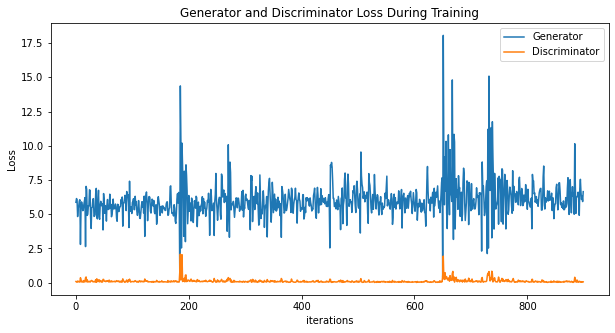

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# GIF visualization

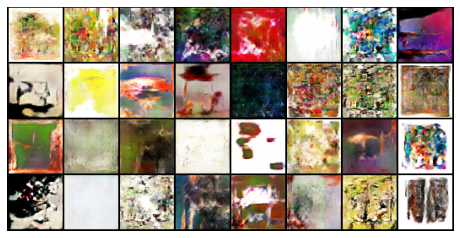

In [18]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Save model

In [19]:
end_epoch = epoch_restore + epochs
save_file = "{}epochs.chkpt".format(end_epoch)

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optim_state_dict' : generator_optim.state_dict(),
            'discriminator_optim_state_dict' : discriminator_optim.state_dict(),}, save_file)